In [1]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.


#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import os, sys
HOME = "/home/jolea/anaconda3/git/qiskit-ignis/"
QISKIT_ROOT = HOME
root_dir = os.path.expanduser(QISKIT_ROOT)
sys.path = [os.path.expanduser(QISKIT_ROOT)] + sys.path

#from qiskit1.ignis.verification.randomized_benchmarking \
#    import PauliUtils as plutils

#Import the RB Functions
import qiskit1.ignis.verification.randomized_benchmarking as rb

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error


In [2]:
#______________________________________________________________________________________

#Generate RB circuits (2Q RB)

#number of qubits
nQ=2 
rb_opts = {}
#Number of Paulis in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
#Number of seeds (random sequences)
rb_opts['nseeds'] = 5 
#Default pattern
rb_opts['rb_pattern'] = [[0,1]]
rb_opts['group_gates'] = 'Pauli'

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [3]:
#______________________________________________________________________________________

print(rb_circs[0][0])

#______________________________________________________________________________________


         ┌───┐ ░ ┌───┐┌─┐
qr_0: |0>┤ X ├─░─┤ X ├┤M├
         └───┘ ░ └┬─┬┘└╥┘
qr_1: |0>──────░──┤M├──╫─
               ░  └╥┘  ║ 
 cr_0: 0 ══════════╬═══╩═
                   ║     
 cr_1: 0 ══════════╩═════
                         


In [4]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)
	
#______________________________________________________________________________________


In [5]:
# The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(),3))

#______________________________________________________________________________________


[[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [6]:
# Run on a noisy simulator
noise_model = NoiseModel()
# Depolarizing_error
p1Q = 0.002
p2Q = 0.02
#noise_model.add_all_qubit_quantum_error(depolarizing_error(dp, 1), ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(depolarizing_error(2*dp, 2), 'cx')

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')


backend = qiskit.Aer.get_backend('qasm_simulator')
#______________________________________________________________________________________


In [7]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
qobj_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    qobj_list.append(qobj)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

#______________________________________________________________________________________


Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.998100, EPC: 0.001425
Compiling seed 1
Simulating seed 1
After seed 1, alpha: 0.998296, EPC: 0.001278
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.998251, EPC: 0.001312
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.996328, EPC: 0.002754
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.996373, EPC: 0.002720


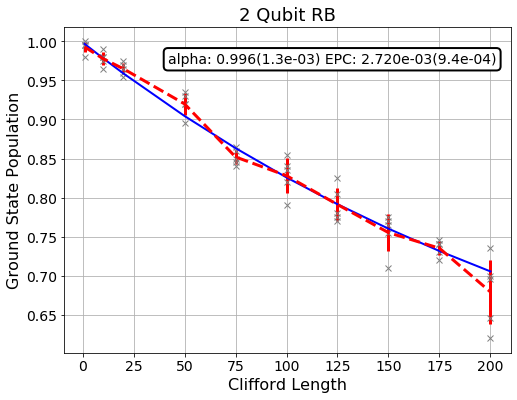

In [8]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()


#______________________________________________________________________________________


In [9]:
#Count the number of single and 2Q gates in the 2Q Pauli
gates_per_cliff = rb.rb_utils.gates_per_clifford(qobj_list, xdata[0],basis_gates, rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per Pauli: %f"%(basis_gates[i],
                                                 np.mean([gates_per_cliff[0][i],gates_per_cliff[1][i]])))
#______________________________________________________________________________________


Number of u1 gates per Pauli: 0.246070
Number of u2 gates per Pauli: 0.000000
Number of u3 gates per Pauli: 0.503930
Number of cx gates per Pauli: 0.000000


In [10]:
# Prepare lists of the number of qubits and the errors
ngates = np.zeros(7)
ngates[0:3] = gates_per_cliff[0][0:3]
ngates[3:6] = gates_per_cliff[1][0:3]
ngates[6] = gates_per_cliff[0][3]
gate_qubits = np.array([0, 0, 0, 1, 1, 1, -1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1, 4]] = p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2, 5]] = 2*p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = p2Q*3/4 #convert from depolarizing error to epg (2Q)

#Calculate the predicted epc
pred_epc = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per Pauli: %e"%pred_epc)

Predicted 2Q Error per Pauli: 2.419436e-03
